# Benchmarking spike sorters


To benchmark the spike sorting algorithms, one of the easiest option is to design artifical dataset, in order to have a full control on what is created, and to have a proper "ground truth" to compare with. 

To do so, we could use MEArec (https://github.com/alejoe91/MEArec) a python package that can help you to generate such artificial datasets.

Since 2024, spikeinterface has a builtin and powerfull generator able to simulated ground truth recording with drift.


Basically, given some templates and a probe layout, the software will generate traces that can later be used for benchmarking the sorting algorithms. 

The comparison between different sorters can be tedious, since every one of them has a different file format. However, spikeinterface can act as a universal wrapper allowing you to launch and read the results of the sorters. Moreover, spikeinterface comes with numerous analysis functions that will allow you to quickly assess the quality of a spike sorting, and compute quality metrics with respect to the Ground Truth that have been generated



In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import spikeinterface.full as si

In [2]:
%matplotlib inline

In [3]:
si.set_global_job_kwargs(n_jobs=-1, progress_bar=True, chunk_duration="1s")

In [4]:
base_folder = Path('/home/samuel/DataSpikeSorting/Ediburgh_SI_tutos/')

### Step 1 : Generate GT recording : one "static" + one "drifting"

`spikeinterface.generation` provide many tools to generate: spiketrains, templates, handle template library.

Here lets use the function `generate_drifting_recording()`.

In [5]:
recording, drifting_recording, gt_sorting = si.generate_drifting_recording(
    num_units=50,
    duration=300.,
    probe_name="Neuronexus-32",
    # probe_name="Neuropixel-128",

    generate_templates_kwargs=dict(
        ms_before=1.5,
        ms_after=3.0,
        mode="ellipsoid",
        unit_params=dict(
            alpha=(150.0, 500.0),
            spatial_decay=(10, 40),
        ),
    ),
    generate_unit_locations_kwargs=dict(
        margin_um=10.0,
        minimum_z=6.0,
        maximum_z=25.0,
        minimum_distance=18.0,
        max_iteration=100,
        distance_strict=False,
    ),    
    generate_sorting_kwargs=dict(
        firing_rates=(2.0, 5.0),
        refractory_period_ms=4.0
    ),
    generate_noise_kwargs=dict(
        noise_levels=(12.0, 15.0),
        spatial_decay=25.0
    ),
    seed=2205
)

In [6]:
print(recording)
print(drifting_recording)
print(gt_sorting)


InjectDriftingTemplatesRecording: 32 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                                  300.00s (5.00 minutes) - float32 dtype - 1.07 GiB
InjectDriftingTemplatesRecording: 32 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                                  300.00s (5.00 minutes) - float32 dtype - 1.07 GiB
NumpySorting: 50 units - 1 segments - 30.0kHz


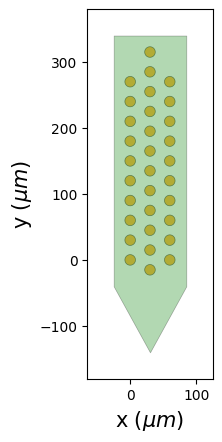

In [7]:
si.plot_probe_map(recording)

### Step 2 : check the ground truth  the dataset with Analyzer

In [29]:
gt_analyzer = si.create_sorting_analyzer(gt_sorting, recording, sparse=True)
gt_analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"])
gt_analyzer.compute(["spike_amplitudes", "unit_locations",  "correlograms", "template_similarity"])
# "principal_components",
gt_analyzer.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
gt_analyzer

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/50 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/50 [00:00<?, ?it/s]

Compute : spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 32 channels - 50 units - 1 segments - memory - sparse - has recording
Loaded 10 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, principal_components, correlograms, template_similarity, spike_amplitudes, quality_metrics

In [30]:
%gui qt
si.plot_sorting_summary(gt_analyzer, backend="spikeinterface_gui")

In [31]:
metrics = gt_analyzer.get_extension("quality_metrics").get_data()
metrics.head(10)

,amplitude_cutoff,rp_contamination,rp_violations,snr
0,0.004457,0.0,0.0,6.956720
1,0.000565,0.0,0.0,6.182963
2,0.000430,0.0,0.0,5.792810
3,0.001907,0.0,0.0,0.717674
4,0.001697,0.0,0.0,4.489210
5,0.000533,0.0,0.0,6.924349
6,0.000891,0.0,0.0,10.570908
7,0.000184,0.0,0.0,8.676829
8,0.000635,0.0,0.0,12.202497
9,0.000219,0.0,0.0,6.058457


Text(0.5, 0, 'snr')

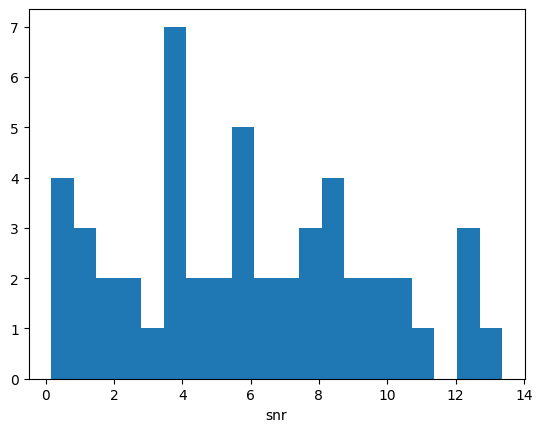

In [32]:
fig, ax = plt.subplots()
_ = ax.hist(metrics['snr'], bins=20)
ax.set_xlabel('snr')

## Step 3 : run several sorters on GT recording

In [15]:
sorter_names = ['spykingcircus2',   'mountainsort5',] # 'kilosort4',

In [17]:
# run sorter (if not already done)
sortings = {}
for sorter_name in sorter_names:
    output_folder = base_folder / f'Simulated_sorter_output_{sorter_name}'
    print(sorter_name, output_folder)
    if output_folder.exists():
        sortings[sorter_name] = si.read_sorter_folder(output_folder)
    else:
        sortings[sorter_name] = si.run_sorter(sorter_name, recording, output_folder, verbose=True)


spykingcircus2 /home/samuel/DataSpikeSorting/Ediburgh_SI_tutos/Simulated_sorter_output_spykingcircus2
mountainsort5 /home/samuel/DataSpikeSorting/Ediburgh_SI_tutos/Simulated_sorter_output_mountainsort5
Warning! The recording is already filtered, but mountainsort5 filter is enabled
filtering
whitening
write_binary_recording 
n_jobs=12 - samples_per_chunk=30,000 - chunk_memory=3.66 MiB - total_memory=43.95 MiB - chunk_duration=1.00s


write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]

Using training recording of duration 300 sec with the sampling mode uniform
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.000 seconds ***
Running phase 1 sorting
Number of channels: 32
Number of timepoints: 9000000
Sampling frequency: 30000.0 Hz
Channel 0: [0. 0.]
Channel 1: [ 0. 30.]
Channel 2: [ 0. 60.]
Channel 3: [ 0. 90.]
Channel 4: [  0. 120.]
Channel 5: [  0. 150.]
Channel 6: [  0. 180.]
Channel 7: [  0. 210.]
Channel 8: [  0. 240.]
Channel 9: [  0. 270.]
Channel 10: [ 30. -15.]
Channel 11: [30. 15.]
Channel 12: [30. 45.]
Channel 13: [30. 75.]
Channel 14: [ 30. 105.]
Channel 15: [ 30. 135.]
Channel 16: [ 30. 165.]
Channel 17: [ 30. 195.]
Channel 18: [ 30. 225.]
Channel 19: [ 30. 255.]
Channel 20: [ 30. 285.]
Channel 21: [ 30. 315.]
Channel 22: [60.  0.]
Channel 23: [60. 30.]
Channel 24: [60. 60.]
Channel 25: [60. 90.]
Channel 26: [ 60. 120.]
Channel 27: [ 60. 150.]
Channel 28: [ 60. 180.]
Channel 29: [ 60. 210.]
Channel 30: [ 60. 240.]
Channel 31: [ 60. 2

In [18]:
sortings

{'spykingcircus2': NumpyFolderSorting: 83 units - 1 segments - 30.0kHz,
 'mountainsort5': NpzSortingExtractor: 44 units - 1 segments - 30.0kHz
   file_path: /home/samuel/DataSpikeSorting/Ediburgh_SI_tutos/Simulated_sorter_output_mountainsort5/sorter_output/firings.npz}

## Step 4 : run comparison and plot agreement matrix for one sorter

Once we have a given spike sorting, we can always compare it to its ground-truth, via the comparison object offered by spikeinterface

In [19]:
comparisons = {}
for sorter_name in sorter_names:
    comparisons[sorter_name] = si.compare_sorter_to_ground_truth(gt_sorting, sortings[sorter_name])

In [20]:
comp_sc2 = comparisons['spykingcircus2']
# comp_ks4 = comparisons['kilosort4']
# comp_ms5 = comparisons['mountainsort5']

In [25]:
comp_sc2.agreement_scores.head(5)

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,88,89,90,92,93,96,97
0,0.000883,0.001640,0.001217,0.001661,0.002380,0.008904,0.002657,0.466917,0.006261,0.001728,...,0.002072,0.002934,0.000722,0.001334,0.000000,0.001567,0.002176,0.000398,0.000000,0.000000
1,0.002418,0.001464,0.001074,0.002813,0.002849,0.003147,0.001209,0.002096,0.002128,0.001973,...,0.000000,0.002649,0.000623,0.001163,0.000000,0.000936,0.000793,0.003305,0.000743,0.000000
2,0.002656,0.000547,0.001219,0.000000,0.001700,0.001220,0.002660,0.002889,0.001996,0.002596,...,0.001382,0.000488,0.000000,0.000668,0.000000,0.000522,0.001305,0.000000,0.000000,0.000000
3,0.000465,0.001752,0.001311,0.000000,0.001769,0.000632,0.002334,0.000998,0.001026,0.002276,...,0.000000,0.001035,0.000000,0.002172,0.000000,0.000556,0.000000,0.000836,0.000000,0.000867
4,0.001431,0.001806,0.001356,0.000000,0.003248,0.003218,0.001433,0.002033,0.001561,0.000931,...,0.001561,0.002129,0.002469,0.000000,0.001117,0.001717,0.002347,0.002138,0.000000,0.000000


In [26]:
comp_sc2.get_performance().head(5)

,accuracy,recall,precision,false_discovery_rate,miss_rate
gt_unit_id,,,,,
0,0,0,0,0,0
1,0.818923,0.818923,1.0,0.0,0.181077
2,0.74502,0.74502,1.0,0.0,0.25498
3,0,0,0,0,0
4,1.0,1.0,1.0,0.0,0.0


(2, 1)


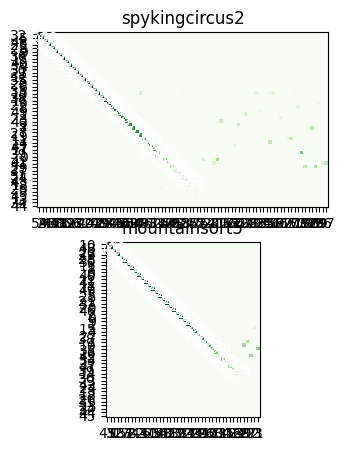

In [33]:
%matplotlib inline
n = len(sorter_names)
fig, axs = plt.subplots(nrows=n, figsize=(10, 5), squeeze=False)

print(axs.shape)

for i, sorter_name in enumerate(sorter_names):
    ax=axs.flatten()[i]
    si.plot_agreement_matrix(comparisons[sorter_name], ax=ax)
    ax.set_title(sorter_name)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
plt.show()

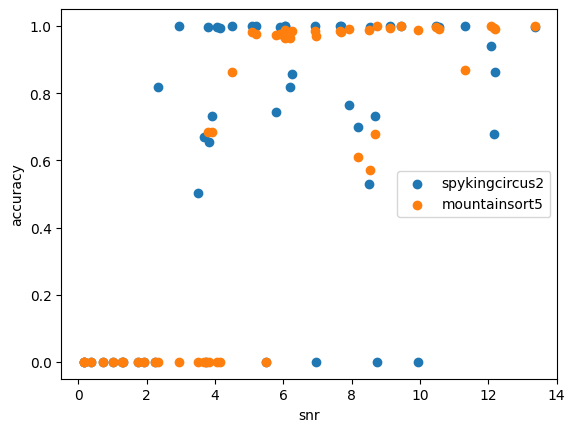

In [40]:
n = len(sorter_names)
fig, ax = plt.subplots()
for i, sorter_name in enumerate(sorter_names):
    comp = comparisons[sorter_name]
    perfs = comp.get_performance()

    x = metrics.loc[:, 'snr'].values
    y = perfs.loc[:, "accuracy"].values
    ax.scatter(x, y, label=sorter_name)
ax.set_ylabel("accuracy")
ax.set_xlabel("snr")
ax.legend()


## Step 5 : agreement between sorters

What if we have several spike sorting algorithms, and want to quickly compare each of them? The comparison could be performed on a single recording, and/or or various recordings at once, to get a more global comparison. 

Let's first start with the simple case of a single comparison, on a single recording. As said, you can easily, with spikeinterface, compare the results accross sorters. To do so, the simplest option is to launch the sorters individually, and compare the results via a so-called aggrement study

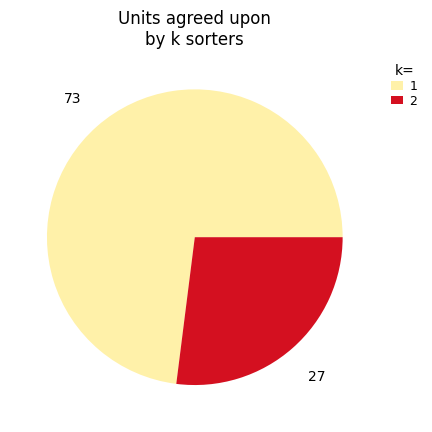

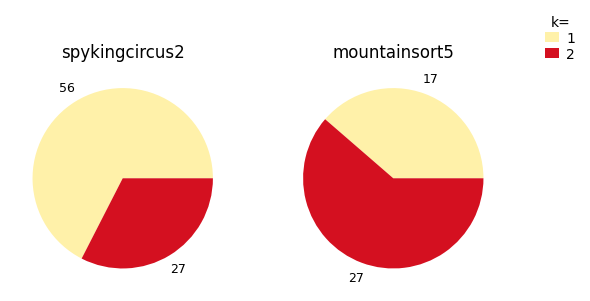

In [42]:
multi_comp = si.compare_multiple_sorters(list(sortings.values()), sorter_names)
si.plot_multicomparison_agreement(multi_comp)
si.plot_multicomparison_agreement_by_sorter(multi_comp)